# Lagrangian tools using Parcels and xarray

In [1]:
from parcels import FieldSet, Field
from glob import glob
import os
from os.path import join
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import cmocean

seconds_per_day = 24*60*60
deg_to_m = 1852 * 60  # m per degree

In [2]:
%load_ext autoreload
%autoreload 2

import lagrangian_tools.lagrangian_tools as lt
from lagrangian_tools import grid_calc
from custommap import *

In [3]:
# not used at the moment 
# interpolate the vorticity for the time range
def time_indices(day, T, dt):
    t0 = (day - datetime(1950, 1, 1)).days
    if dt > timedelta(seconds=0):
        tf = t0 + T.days
        tr = slice(np.argmin(np.abs(ds.time.data-t0)), np.argmin(np.abs(ds.time.data-tf)))
    else:
        tf = t0 - T.days
        tr = slice(np.argmin(np.abs(ds.time.data-tf)), np.argmin(np.abs(ds.time.data-t0)))
    return tr

def vorticity(ds):
    # assume that the grid is 0.25˚ uniform
    dy_m = np.ones((len(ds.time), len(ds.latitude) - 1, len(ds.longitude) - 1)) * 0.25 * deg_to_m  # m
    cos_mid_lat = np.cos(np.radians(np.convolve(ds.latitude, [0.5, 0.5], mode='valid')))
    dx_m = dy_m * cos_mid_lat[np.newaxis, :, np.newaxis]  # non uniform dx f(lat)
    return ds.vgos.diff('longitude')[:,1:,:]/dx_m - ds.ugos.diff('latitude')[:,:,1:]/dy_m

# load one month of data for the test

In [4]:
xr.open_dataset('1995-01.nc')

<xarray.Dataset>
Dimensions:    (time: 31, latitude: 171, longitude: 173)
Coordinates:
  * latitude   (latitude) float32 7.375 7.625 7.875 8.125 ... 49.38 49.62 49.88
  * time       (time) datetime64[ns] 1995-01-01 1995-01-02 ... 1995-01-31
  * longitude  (longitude) float32 -98.12 -97.88 -97.62 ... -55.62 -55.38 -55.12
Data variables:
    adt        (time, latitude, longitude) float64 ...
    ugos       (time, latitude, longitude) float64 ...
    vgos       (time, latitude, longitude) float64 ...
    vgosa      (time, latitude, longitude) float64 ...
    crs        int32 ...
    sla        (time, latitude, longitude) float64 ...
    ugosa      (time, latitude, longitude) float64 ...
    err_sla    (time, latitude, longitude) float64 ...
Attributes: (12/45)
    Conventions:                                    CF-1.6
    FROM_ORIGINAL_FILE__Metadata_Conventions:       Unidata Dataset Discovery...
    cdm_data_type:                                  Grid
    comment:                                        Sea Surface Height measur...
    contact:                                        servicedesk.cmems@mercato...
    creator_email:                                  servicedesk.cmems@mercato...
    ...                                             ...
    time_coverage_duration:                         P1D
    time_coverage_end:                              2021-08-02T12:00:00Z
    time_coverage_resolution:                       P1D
    time_coverage_start:                            2021-08-01T12:00:00Z
    title:                                          DT merged all satellites ...
    _CoordSysBuilder:                               ucar.nc2.dataset.conv.CF1...

In [5]:
# read velocities
folder = './'
files = sorted(glob(join(folder, f'*.nc')))

# filename, variables, and dictionnary for dimensions
filenames = {'U': files,
             'V': files}
variables = {'U': 'ugos',
             'V': 'vgos'}

dimensions = {'time' : 'time',
              'lon': 'longitude',
              'lat': 'latitude',
              }

#timestamps = np.expand_dims([i*seconds_per_day*1.0 for i in range(0, 31)], axis=1)
# timestamps=timestamps,

# create the velocity field for c-grid interpolation
fs = FieldSet.from_netcdf(filenames, variables, dimensions, mesh='spherical', 
                          time_periodic=False, chunksize=False, vmin=-5, vmax=5)

In [6]:
fs

In [7]:
fs.time_origin

1995-01-01T00:00:00.000000000

# Calculating vorticity along the velocity fields

LAVD requires interpolating the vorticity along the trajectories, so we include it as an extra field to the Parcel's fieldset object `fs`.

In [8]:
# create extra field for vorticity
ds = xr.open_mfdataset(files, decode_times=False)

# vorticity using forward, central, and backward finite differences
mx, my = np.meshgrid(ds.longitude.data, ds.latitude.data, indexing='ij')
vort = grid_calc.vorticity(mx, my, np.swapaxes(ds.ugos.to_numpy(),1,2), np.swapaxes(ds.vgos.to_numpy(),1,2))
ds["vort"] = (["time","latitude","longitude"], np.swapaxes(vort,1,2))

# add the field to the FS object
field1 = Field('vorticity', ds.vort, lon=ds.longitude.values, lat=ds.latitude.values, time=fs.U.grid.time, interp_method='linear')
field1.grid.time_origin = fs.U.grid.time_origin
fs.add_field(field1)

## simply to validate the vorticity

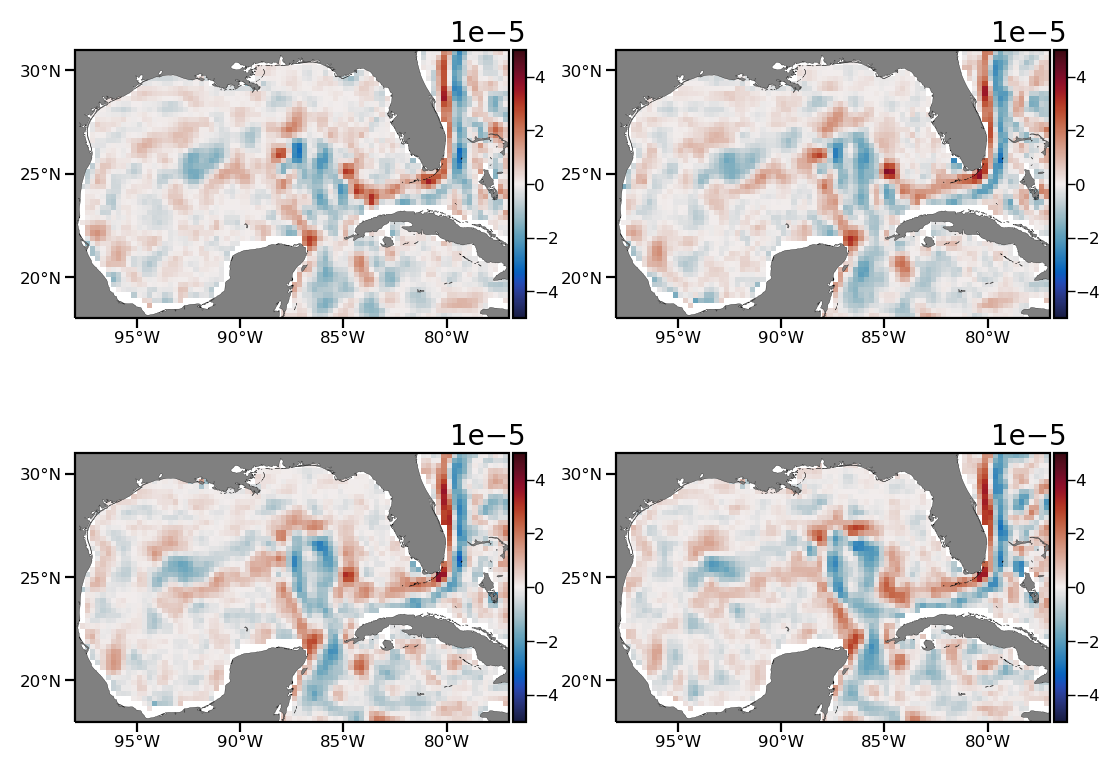

In [9]:
fig = plt.figure(dpi=200)
ax1 = fig.add_subplot(2,2,1,aspect='equal', projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(2,2,2,aspect='equal', projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(2,2,3,aspect='equal', projection=ccrs.PlateCarree())
ax4 = fig.add_subplot(2,2,4,aspect='equal', projection=ccrs.PlateCarree())

for i, ax in enumerate([ax1,ax2,ax3,ax4]):
    pcm = ax.pcolormesh(ds.longitude, ds.latitude, ds.vort[i*7], cmap=cmocean.cm.balance, vmin=-5e-5, vmax=5e-5)
    gom_map(ax)
    add_colorbar(fig,ax,pcm)

# Trajectories

In [10]:
# parameters
adv_time = timedelta(days=5)
adv_dt = -timedelta(hours=12)
pdist = 0.025  # distance in degrees between particles
lon = [-98, -75]
lat = [17, 31]
px = np.arange(lon[0], lon[1]-pdist, pdist)
py = np.arange(lat[0], lat[1]+pdist, pdist)

In [11]:
ds_t = xr.open_dataset('lavd_015.zarr')

/home/pmiron/micromamba/envs/parcels/lib/python3.10/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/pmiron/micromamba/envs/parcels/lib/python3.10/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [12]:
ds_t

<xarray.Dataset>
Dimensions:     (trajectory: 425395, obs: 11)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 8 9 10
  * trajectory  (trajectory) int64 2062452 2062453 2062454 ... 2577793 2577794
Data variables:
    lat         (trajectory, obs) float32 ...
    lon         (trajectory, obs) float32 ...
    time        (trajectory, obs) datetime64[ns] ...
    vorticity   (trajectory, obs) float32 ...
    z           (trajectory, obs) float32 ...
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.0

In [13]:
ds_t.trajectory

<xarray.DataArray 'trajectory' (trajectory: 425395)>
array([2062452, 2062453, 2062454, ..., 2577792, 2577793, 2577794])
Coordinates:
  * trajectory  (trajectory) int64 2062452 2062453 2062454 ... 2577793 2577794

In [14]:
folder = "./"
for i in range(15, 16):           
    t0 = timedelta(days=i).total_seconds()  # from initial time
    pset, id0, fm = lt.flowmap_lavd(join(folder, f"lavd_{i:03d}.zarr"), fs, px, py, t0, adv_time, adv_dt)
    # evaluate the Flowmap derivatives to construct the Cauchy-Green tensor
    # this is step is not required for the LAVD but we get the Finite-Time Lyapunov Exponent (ftle)
    fm = lt.cauchygreen(fm)
    lmin, lmax, vmin, vmax, ftle = lt.eigenspectrum(fm.cg.values, adv_time.days*seconds_per_day)
    
    # calculate LAVD from the Parcel's outputs
    with xr.open_dataset(join(folder, f"lavd_{i:03d}.zarr")) as ds_out:
        lavd = lt.lavd(ds_out, np.nanmean(vort), int(abs(adv_dt.total_seconds())), id0, (len(px), len(py)))
    
    np.savez_compressed(join(folder, f"lavd_{i:03d}"),
                        lon=fm.longitude.values[:,0],
                        lat=fm.latitude.values[0,:],
                        ftle=ftle,
                        lavd=lavd)
    del pset

INFO: Compiled ArrayLAVDParticleRemoveOnLand ==> /tmp/parcels-1043/lib88f6bb214d290f14db009d777f28c7c6_0.so
INFO: Compiled ArrayLAVDParticleSampleVorticityAdvectionRK4 ==> /tmp/parcels-1043/lib30bce62328a6b0c0e6884722466a903f_0.so
100%|██████████████████████████████████████████████████████████████████████████████████████████| 432000.0/432000.0 [00:11<00:00, 36609.51it/s]
/home/pmiron/micromamba/envs/parcels/lib/python3.10/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/pmiron/micromamba/envs/parcels/lib/python3.10/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


## plot results

In [15]:
day = datetime(1995, 1, 15)
folder = './'
data = np.load(join(folder, f"lavd_{i:03d}.npz"))
lon = data['lon']
lat = data['lat']
ftle = data['ftle']
lavd = data['lavd']

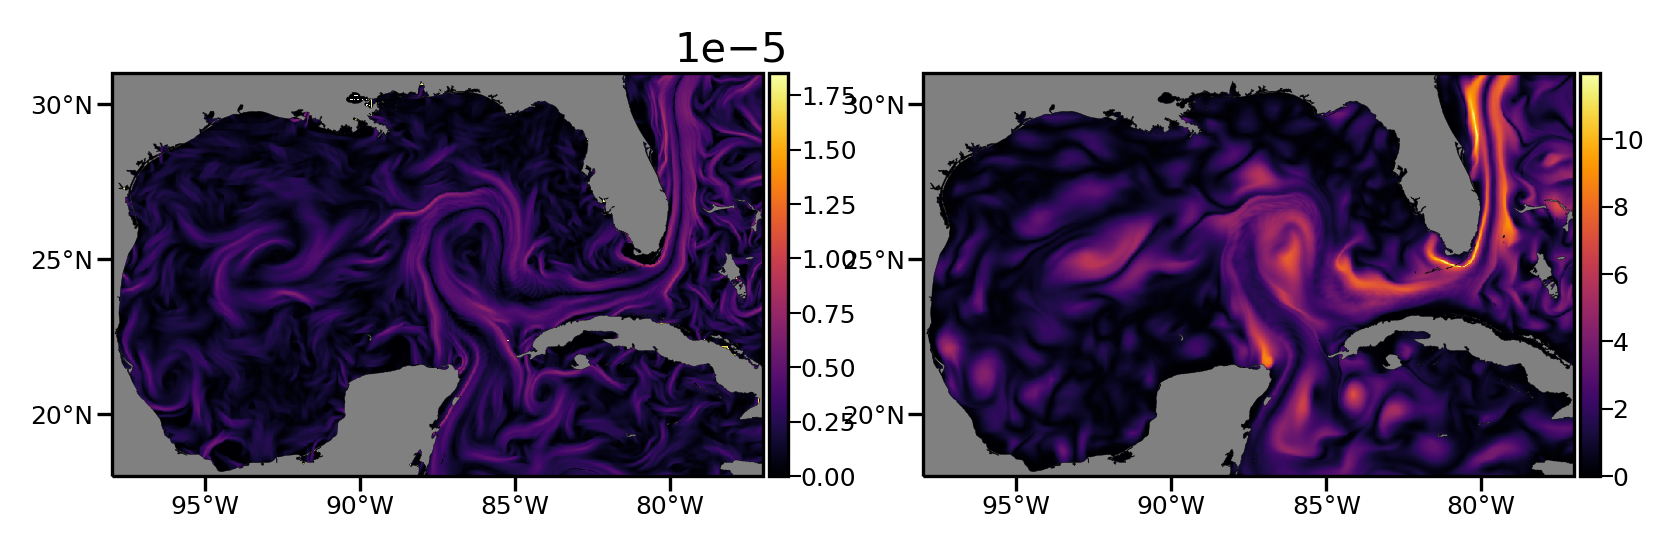

In [16]:
fig = plt.figure(dpi=300)
ax1 = fig.add_subplot(1,2,1,aspect='equal', projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(1,2,2,aspect='equal', projection=ccrs.PlateCarree())

ftle[ftle<0] = 0  # only positive values are meaningful
pcm = ax1.pcolormesh(lon, lat, ftle.T, cmap='inferno')
gom_map(ax1)
add_colorbar(fig, ax1, pcm)
pcm = ax2.pcolormesh(lon, lat, lavd.T, cmap='inferno')
gom_map(ax2)
add_colorbar(fig, ax2, pcm)

# Extract Contour

In [17]:
%load_ext autoreload
%autoreload 2
from lagrangian_tools.contours import extract_contours

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# parameters
defTol = 0.075      # [%] control the deficiency of the loop closer to 0 means perfectly convex (~circular)

# try extracting contours around each identified peaks
# number_levels represents the number of "test" contour between [0, peak_lavd_value] 
number_levels = 50  

# data
for i in range(15, 16):    
    # data
    folder = './'
    data = np.load(join(folder, f"lavd_{i:03d}.npz"))
    lon = data['lon']
    lat = data['lat']
    lavd = data['lavd']
    
    peaks_xy, peaks_contour = extract_contours(lon, lat, lavd, defTol, number_levels)
    
    #np.save(join(folder, f"peaks_xy_{i:03d}"), peaks_xy)
    #np.save(join(folder, f"contours_{i:03d}"), peaks_contour, allow_pickle=True)

/nexsan/people/pmiron/projects_mars/goffish/data_example/lagrangian_tools/contours.py:23: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  main_area = np.dot(x[:-1], y[1:]) - np.dot(y[:-1], x[1:])
/nexsan/people/pmiron/projects_mars/goffish/data_example/lagrangian_tools/contours.py:23: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  main_area = np.dot(x[:-1], y[1:]) - np.dot(y[:-1], x[1:])


## plot contours

In [ ]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1,1,1,aspect='equal', projection=ccrs.PlateCarree())
pcm = ax.pcolormesh(lon, lat, lavd.T, cmap=cmocean.cm.rain)

cc = 0
for c in peaks_contour:
    if c is not None:
        ax.plot(c[:,0], c[:,1], linewidth=0.5)

ax.scatter(lon[peaks_xy[:,0]], lat[peaks_xy[:,1]], s=0.1)
gom_map(ax)